# Image classification

In this notebook, we build a Neural Network Classifier model from the generated digits data.

## Data

The data is white digits on a black background. Below we will show some images.

In [2]:
#import useful libraries
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#load the dataframe
train_data = pd.read_csv('data/train.csv')

train_data.sample(5)

,name,label
677,8_61.jpg,8
620,8_4.jpg,8
506,6_44.jpg,6
243,3_12.jpg,3
266,3_35.jpg,3


The dataframe contains the name of the images as well as the label. The format is the following : the first digit of file's name designs the digit represented in the image. 

For instance, `2_18` is the 18th image representing the digit 2 in our dataset.

Now we will show some images

Shape of an image :  (44, 28, 3)


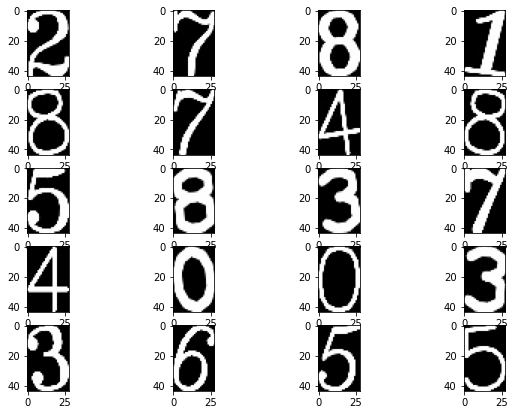

In [4]:
#Print some images :
#define the path 
path = 'data/train/'

#sample 20 images from the training data
img_ex = train_data.sample(20)
img_ex.reset_index(drop=True, inplace=True) #reset the index

#plot
fig, axs = plt.subplots(5,4, figsize=(10,7))

for ind, row in img_ex.iterrows():
    file_path=path+row['name']
    if ind==0:
        print('Shape of an image : ', cv2.imread(file_path).shape)
    axs[ind%5, ind%4].imshow(cv2.imread(file_path))

## Classification 

The idea is to convert images into big numpy arrays. We give this array to a network, we have the label, we predict the number.

As we saw while generating the digits, we use 7 fonts for training images, and one different font for testing images.

Sources : 
- Pytorch Networks : https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
- CNNs : https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/


In [5]:
#import libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

In [44]:
#load the training and testing data
def load_data(path_csv, path_img):
    '''
    This function takes as an argument the paths for the csv training/testing file as well as the path for the images, and 
    returns x and y
    
    Input : -'path_csv' : path that links to the exact csv file (must finish by '.csv')
            -'path_img' : path that links to the repository where all the images are stored
            -'size_img' : desired size (not counting the RGB channels) for the imported images (original size is 640x480)
    
    Output : -'x' : array containing the image representation for each image 
             -'y' : array of labels associated to x_train arrays
    '''
    #initialize x_train and y_train
    x=[]
    y=[]
    
    #load the dataframe
    train_data = pd.read_csv(path_csv)
    
    #loop over all rows of this dataframe to construct x_train and y_train
    for ind, row in train_data.iterrows():
        img = cv2.imread(path_img+row['name']) #load the image
        img = img/255.0 #normalizing the pixel values
        img = img.astype('float32') #converting the type of pixel to float 32
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to gray scale
        
        #add the array representing the image into x_train and the label into y_train
        x.append(gray)
        y.append(row['label'])
        
    #convert to arrays
    x = np.array(x)
    y = np.array(y)
        
    return x, y
    
x_train, y_train = load_data(path_csv='data/train.csv',
                             path_img='data/train/')

x_test, y_test = load_data(path_csv='data/test.csv',
                             path_img='data/test/')


print('Shape of x_train : {}  |||||  Shape of y_train : {}'.format(x_train.shape, y_train.shape))
print('Shape of x_test : {}  |||||  Shape of y_test : {}'.format(x_test.shape, y_test.shape))

Shape of x_train : (770, 44, 28)  |||||  Shape of y_train : (770,)
Shape of x_test : (110, 44, 28)  |||||  Shape of y_test : (110,)


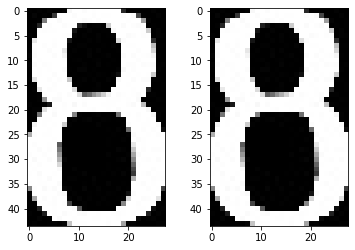

In [45]:
path = 'data/train/'
#test in normalizing pixel values
img = cv2.imread(path+train_data['name'][650])
# normalizing the pixel values
img_bis = img/255.0
# converting the type of pixel to float 32
img_bis = img_bis.astype('float32')
gray = cv2.cvtColor(img_bis, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(img_bis)

**Define the class (model + training/testing functions)**

In [7]:
class img_class(nn.Module):
    '''  Class implenting the network that will classify the images    '''
    
    def __init__(self):
        super(img_class, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3) #first convolution layer
        self.conv2 = nn.Conv2d(6, 16, 3) #second convolution layer
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 9 * 5, 120)  # 9*5 from image dimension after the 2 convolutions+pooling (divide by 4 and substract 2 for both dimensions)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def learn(self, x_train, y_train, loss_function, optimizer, num_epochs):
        ''' Training process '''
        #convert x_train to a torch tensor
        x_train = x_train.reshape(len(x_train), 1, 44, 28) #reshape the array for torch
        tensor_x  = torch.from_numpy(x_train) #create the tensor
        tensor_x.requires_grad_()
        
        #convert y_train to a torch tensor
        tensor_y = torch.from_numpy(y_train)
        tensor_y = tensor_y.long() #convert to float
        
        #training : for each element of the input tensor 'tensor_x', compare the output of the model and the real label
        for i in range(num_epochs):
            
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            self.zero_grad()

            # Step 2 - compute model predictions and loss
            output = self(tensor_x) #output of the model (shape : (1050, 10))
            #pred_label = torch.argmax(output, dim=1)
            #pred_label = pred_label.float()

            #loss
            loss = loss_function(output, tensor_y) 

            # Step 3 - do a backward pass and a gradient update step
            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()

            if i % 10 == 0: #print every 10 epochs
                print('Epoch : {}/{}, Loss : {}'.format(i + 1, num_epochs, loss.item()))
                
    def testing(self, x_test, y_test):
        '''Testing process'''
        #convert x_test into a tensor
        x_test = x_test.reshape(len(x_test), 1, 44, 28) #reshape the array for torch
        tensor_x  = torch.from_numpy(x_test) #create the tensor
        
        #convert y_test to a torch tensor
        tensor_y = torch.from_numpy(y_test)
        tensor_y = tensor_y.long() #convert to float
        
        output = self(tensor_x)
        softmax = torch.exp(output).cpu()
        prob = list(softmax.detach().numpy())
        predictions = np.argmax(prob, axis=1)

        # accuracy on testing set
        print(accuracy_score(y_test, predictions))
        
    def learn2(self, x_train, y_train, x_test, y_test, loss_function, optimizer, num_epochs):
        ''' Training process, second version : to have the training and testing errors '''
        train_losses = []
        test_losses = []
        
        #convert x_train to a torch tensor
        x_train = x_train.reshape(len(x_train), 1, 44, 28) #reshape the array for torch
        tensor_x  = torch.from_numpy(x_train) #create the tensor
        tensor_x.requires_grad_()
        
        #convert y_train to a torch tensor
        tensor_y = torch.from_numpy(y_train)
        tensor_y = tensor_y.long() #convert to float
        
        #convert x_test into a tensor
        x_test = x_test.reshape(len(x_test), 1, 44, 28) #reshape the array for torch
        tensor_xtest  = torch.from_numpy(x_test) #create the tensor
        #convert y_test to a torch tensor
        tensor_ytest = torch.from_numpy(y_test)
        tensor_ytest = tensor_ytest.long() #convert to float
        
        #training : for each element of the input tensor 'tensor_x', compare the output of the model and the real label
        for i in range(num_epochs):
            
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            self.zero_grad()

            # Step 2 - compute model predictions and loss
            output_train = self(tensor_x) #output of the model (shape : (1050, 10))
            output_test  = self(tensor_xtest)
            pred_label = torch.argmax(output_train, dim=1)
            pred_label = pred_label.float() #should be a number

            #loss
            loss_train = loss_function(output_train, tensor_y) 
            loss_test = loss_function(output_test, tensor_ytest)
            train_losses.append(loss_train)
            test_losses.append(loss_test)

            # Step 3 - do a backward pass and a gradient update step
            optimizer.zero_grad()  
            loss_train.backward()
            optimizer.step()

            if i % 10 == 0: #print every 2 epochs
                print('Epoch : {}/{}, Loss : {}'.format(i + 1, num_epochs, loss_train.item()))
        return train_losses, test_losses
    
        
        

**Training**

In [47]:
Net = img_class()
    
    
num_epochs = 40
#define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.005)

Net.learn(x_train, y_train, loss_function, optimizer, num_epochs)

Epoch : 1/40, Loss : 2.306065082550049
Epoch : 11/40, Loss : 0.27001985907554626
Epoch : 21/40, Loss : 0.05330801010131836
Epoch : 31/40, Loss : 0.006596499588340521


In [48]:
Net.testing(x_test, y_test)

1.0


We have very high accuracy on the testing images, this may be overfitting

**Experimenting the saving and loading of models**

In [49]:
torch.save(Net.state_dict(), 'model_fonts') #save the model

In [8]:
#load the model
model = img_class() #create the object
model.load_state_dict(torch.load('model_fonts')) #load
model.eval()

img_class(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=720, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [51]:
model.testing(x_test, y_test) #

1.0


We have the same value as before, which is normal

**2nd training funtion**

Epoch : 1/40, Loss : 2.3046228885650635
Epoch : 11/40, Loss : 0.44784092903137207
Epoch : 21/40, Loss : 0.04700229689478874
Epoch : 31/40, Loss : 0.009152927435934544


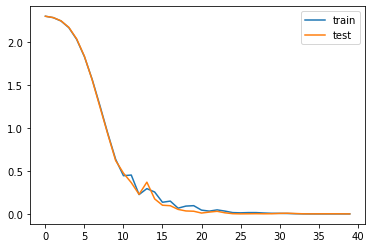

In [18]:
Net = img_class()
    
    
num_epochs = 40
#define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.005)
train_losses, test_losses = Net.learn2(x_train, y_train, x_test, y_test, loss_function, optimizer, num_epochs)

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

**Prediction on a drawing image**

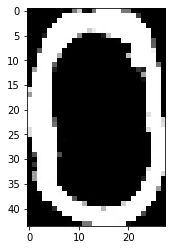

In [11]:
img = cv2.imread('drawing.jpg', 0)
rows, cols = np.where(img==255) #we get rows and cols 
img_centered = img[min(rows):max(rows), min(cols):max(cols)]
img_bis = cv2.resize(img_centered, (28,44))
# normalizing the pixel values
img_bis = img_bis/255.0
# converting the type of pixel to float 32
img_bis = img_bis.astype('float32')

plt.imshow(img_bis, cmap="gray", vmin=0, vmax=1)

In [12]:
#convert to tensor
img_bis = img_bis.reshape(1, 1, 44, 28) #reshape
print(img_bis.shape)
torch_img = torch.from_numpy(img_bis) #convert to tensor

print('prediction : {}'.format(torch.argmax(model(torch_img), dim=1)))

(1, 1, 44, 28)
prediction : tensor([0])
